In [25]:
import numpy as np
import pandas as pd
import os
from sklearn import datasets
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

In [3]:
df = pd.read_csv('../Data/address_data_combined.csv')
df.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,0.040100,0.040100
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,2.650000,-0.284889
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,4.999916,0.000840
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,2.085000,0.000342


In [8]:
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(9908, 12)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
6709,17.06,0.00,51.17,1,101.0000,101.000000,101.000000,10.804780,33.666149,4,101.000000,0.001554
13808,2679.43,2841.02,275214.32,21,0.0001,15.000000,2.295850,0.000000,1.877316,100,103.313259,0.060902
8333,103299.49,37551.75,826452.87,6,0.0000,52.532971,23.290155,0.000000,16.627500,15,163.031084,30.011085
6981,4756.98,11283.84,46352.60,1,11.0000,20.000000,15.500000,9.975152,10.194942,7,31.000000,-19.974711
676,0.00,0.00,0.00,0,0.0000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000


In [9]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
  X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
  X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
# only use training data to fit, to avoid data leakage
# Not required for Naive Bayes but performed to ensure all variables are standardized through all ML models
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [10]:
###Creating Naive Bayes Classifier Model
GNB = GaussianNB(var_smoothing=2e-9)
GNB.fit(X_train_full,y_train_full)
y_pr = GNB.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_pr))
print('F1 Score: ', f1_score(y_test, y_pr))

Accuracy Score:  0.7732517070873558
F1 Score:  0.768231046931408


In [13]:
### Doing Grid Search to find best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'var_smoothing': np.logspace(0, -9, num=100),
}

grid_search_nb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=2, cv=5, scoring='f1')

In [14]:
grid_search_nb.fit(X_train_full,y_train_full)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.6

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='f1', verbose=2)

In [24]:
print("Tuned Hyperparameters :", grid_search_nb.best_params_)
print("Train F1 Score :",grid_search_nb.best_score_)
best_y_pr = grid_search_nb.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'var_smoothing': 0.0533669923120631}
Train F1 Score : 0.7770198619447811
Test F1 Score:  0.7796856106408706


In [37]:
# from sklearn.inspection import permutation_importance
# imps = permutation_importance(grid_search_nb, X_test, y_test)
# # imps['importances']
# imps

{'importances_mean': array([0.00727584, 0.02297295, 0.01314529, 0.04054539, 0.01370441,
        0.02134366, 0.03347484, 0.00929675, 0.00265874, 0.03284236,
        0.03587607, 0.00142932]),
 'importances_std': array([0.00090538, 0.00120308, 0.00242333, 0.00111696, 0.00232361,
        0.00400025, 0.00368724, 0.00192851, 0.00206063, 0.00409337,
        0.0037392 , 0.00120638]),
 'importances': array([[ 0.00721166,  0.00694731,  0.00813912,  0.00829167,  0.00578944],
        [ 0.02111351,  0.02346203,  0.02479981,  0.02252262,  0.02296675],
        [ 0.01024117,  0.01409322,  0.0103835 ,  0.01470651,  0.01630206],
        [ 0.04136785,  0.04212129,  0.03940032,  0.03921821,  0.04061927],
        [ 0.01203855,  0.01004188,  0.01506645,  0.01495084,  0.01642431],
        [ 0.01574139,  0.01863246,  0.02414113,  0.02712119,  0.02108212],
        [ 0.02855439,  0.03269766,  0.03806726,  0.03730334,  0.03075158],
        [ 0.00900801,  0.01287381,  0.0093009 ,  0.00726517,  0.00803588],
      

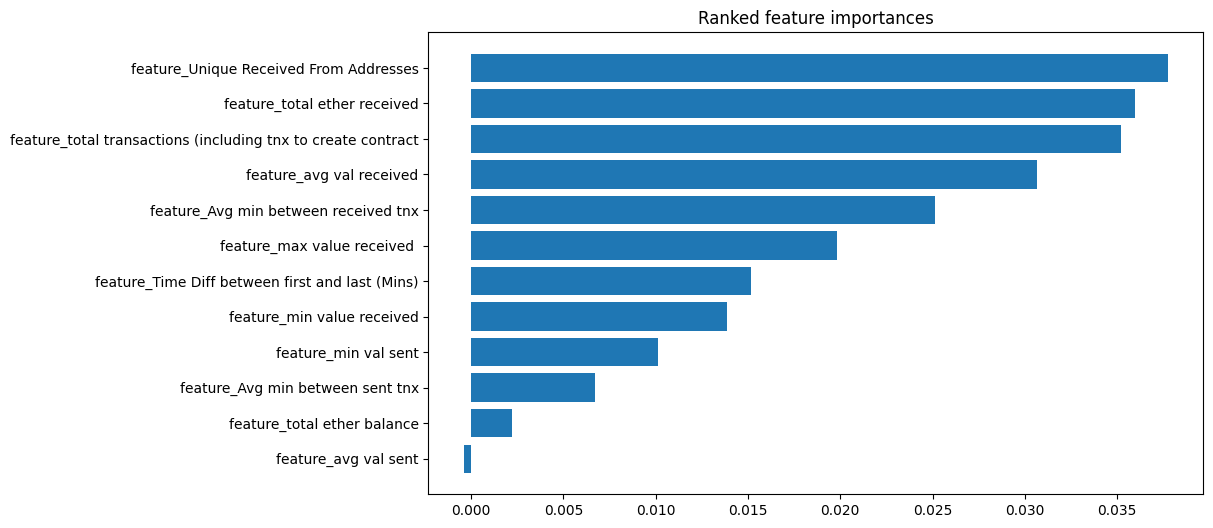

In [38]:
from sklearn.inspection import permutation_importance
feat_importances = permutation_importance(grid_search_nb, X_test, y_test)['importances_mean']
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [15]:
# best_y_pr = grid_search_nb.predict(X_test)
# print('Accuracy Score: ', accuracy_score(y_test, best_y_pr))
# print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Accuracy Score:  0.7854956439839887
F1 Score:  0.7796856106408706


In [ ]:
# best_nb = GaussianNB(var_smoothing=0.0533669923120631)
# best_nb.fit(X_train_full,y_train_full)

GaussianNB(var_smoothing=0.0533669923120631)

In [ ]:
# best_nb.theta_

array([[0.3753114 , 0.54892822, 0.68676335, 0.11545696, 0.81067569,
        0.55676798, 0.57059979, 0.5635936 , 0.65220652, 0.30497745,
        0.55926168, 0.30943354],
       [0.38906671, 0.46369528, 0.5386103 , 0.14103064, 0.77928058,
        0.47821933, 0.50062382, 0.58831371, 0.60499555, 0.19274126,
        0.46400865, 0.3211177 ]])

In [ ]:
# best_nb.var_

array([[0.05071803, 0.0672638 , 0.06402842, 0.02110447, 0.00898148,
        0.01563075, 0.01503675, 0.01420475, 0.01553808, 0.04751733,
        0.0147941 , 0.02812505],
       [0.06648541, 0.04586197, 0.09118215, 0.03047831, 0.00814782,
        0.0103426 , 0.00890123, 0.01260221, 0.01124974, 0.03573011,
        0.01082393, 0.01877809]])

In [ ]:
# best_nb.classes_

array([0, 1])

In [ ]:
# feature_dict = {'feature_name': [], 'mean': [], 'variance': [], 'fraud': []}

# for label in range(len(best_nb.theta_)):
#     for mean, var, col_name in zip(best_nb.theta_[label], best_nb.var_[label], columns):
#     feature_dict['feature_name'].append(col_name)
#     feature_dict['mean'].append(mean)
#     feature_dict['variance'].append(var)
#     feature_dict['fraud'].append(label)

# df2 = pd.DataFrame(feature_dict)

In [ ]:
# df2

,feature_name,mean,variance,fraud
0,Avg min between sent tnx,0.375311,0.050718,0
1,Avg min between received tnx,0.548928,0.067264,0
2,Time Diff between first and last (Mins),0.686763,0.064028,0
3,Unique Received From Addresses,0.115457,0.021104,0
4,min value received,0.810676,0.008981,0
5,max value received,0.556768,0.015631,0
6,avg val received,0.570600,0.015037,0
7,min val sent,0.563594,0.014205,0
8,avg val sent,0.652207,0.015538,0
9,total transactions (including tnx to create co...,0.304977,0.047517,0
